In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from IPython.display import clear_output

from match2hydrolakes import match2hydrolakes

from osgeo import ogr, osr

# used for QA/QC
from hydrolakes import draw_lake

from kpmb_plots_cartopy import find_country

/Users/blagrave/.virtualenvs/icemodels/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


Select lakes from US lakes file

In [2]:
nlakes = 100

dfice = pd.read_csv('../Data/IcePhenology/us_lakes_ts_minimal.csv', low_memory=False)

long_records_lakecode = dfice[~dfice.ice_on_1.isnull() &
                             ~dfice.loc[:,[f'ice_off_{i}' for i in range(1,7)]].isnull().all(axis=1)].groupby('lakecode').lake.count().sort_values().tail(nlakes).index

dftopN = dfice[dfice.lakecode.isin(long_records_lakecode)].groupby('lakecode').apply(lambda x:
                                                                                      pd.Series({'lake':x.lake.dropna().unique()[0], 'start_date':x.start_year.min(),'end_date':x.start_year.max()+1,'lat':x.latitude.unique()[0],'lon':x.longitude.unique()[0]}))
# missing coordinate for Lake Itasca - North # record is missing all together?
if 'xKB0781' in dftopN.index:
    dftopN.loc['xKB0781',['lat','lon']] = 47.23561941185806, -95.20266402552227

In [3]:
dfice.drop_duplicates('lakecode')
dftopN#.lat.mean()

,lake,start_date,end_date,lat,lon
lakecode,,,,,
DMR1,mendota,1852,2019,43.12800,-89.42000
DMR2,monona,1851,2019,43.06700,-89.36600
HB01,mirror,1968,2006,43.94400,-71.69300
JD01,kegonsa,1902,2007,42.96600,-89.25100
JGL01,spirit,1943,2008,43.47700,-95.10200
...,...,...,...,...,...
xKB1820,turtle,1964,2016,47.61765,-94.86755
xKB1881,upper_prior,1962,2017,44.71411,-93.44694
xKB1921,washington,1949,2017,44.25335,-93.87293


Match with HydroLAKES. Removing duplicates and no matches, using column header 'Match'

In [39]:
for i,row in dftopN.iterrows():
    dist,hylak_id = match2hydrolakes(row.lat,row.lon)
    dftopN.loc[i,'Distance'] = dist
    dftopN.loc[i,'Hylak_id'] = hylak_id
    

nohylak = dftopN[(dftopN.Distance==0)].duplicated('Hylak_id',keep=False).replace(False,np.nan).dropna().index

# Kegonsa observed by two different people OK
expected_duplicates = ['JD01','JJM9']

nohylak = [hh for hh in nohylak if hh not in expected_duplicates]

dftopN['Match'] = True
print(len(dftopN[dftopN.index.isin(nohylak)]))
print(len(dftopN[dftopN.Hylak_id.isnull()]))
dftopN.loc[dftopN.index.isin(nohylak) | dftopN.Hylak_id.isnull(),'Match'] = False
print(len(dftopN[dftopN.index.isin(nohylak) | dftopN.Hylak_id.isnull()]))

8
9
17


In [40]:
nohylak

['JGL02', 'JGL03', 'JJM30', 'JJM33', 'JJM7', 'JJM8', 'RAA3', 'RAA4']

### QA/QC
a) Cycle through HydroLAKES matches where point lies outside of polygon

crystal_bog 46.0 -89.6
placid 44.304 -73.995
deep 43.03 -77.57
lake_of_the_isles 44.95538 -93.30705
long 46.81725 -95.89779
washington 44.25335 -93.87293


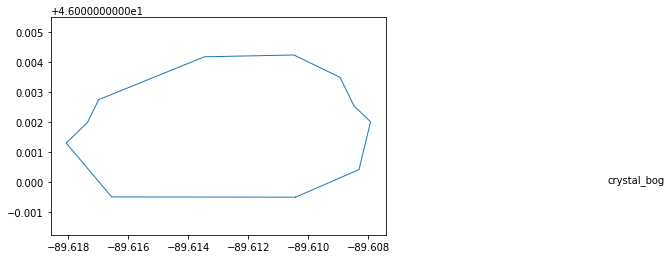

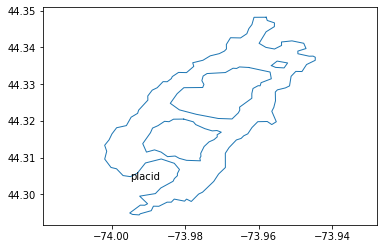

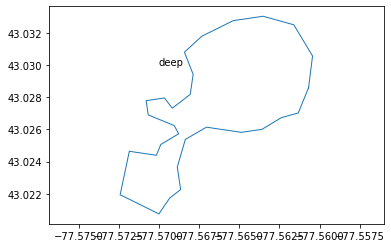

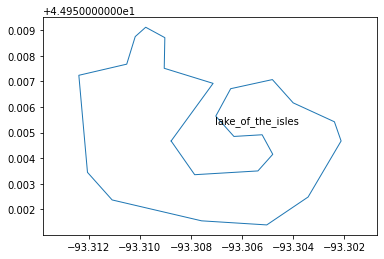

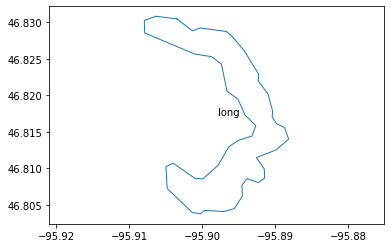

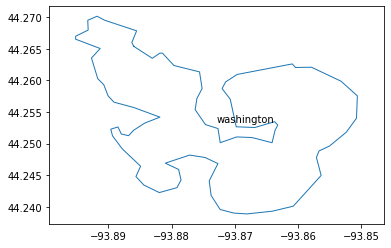

In [41]:
for i,row in dftopN[dftopN.Match & (dftopN.Distance>0)].iterrows():
    ax=draw_lake(int(row.Hylak_id))
    ax.text(row.lon,row.lat, row.lake)
    print(row.lake, row.lat, row.lon)

b) Cycle through all HydroLAKES matches.

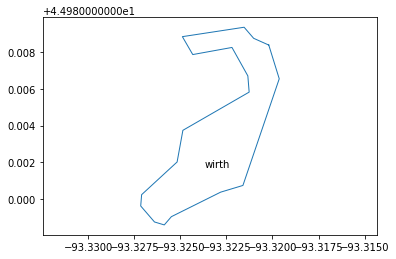

Continue?


In [42]:
for i, row in dftopN.loc[dftopN.Match,['lake','Hylak_id','lat','lon']].iterrows():
    ax = draw_lake(int(row.Hylak_id))
    ax.text(row.lon,row.lat,row.lake)
    plt.show()
    input('Continue?')
    clear_output(wait=True)

Remove these HydroLAKES matches, based on visual inspections above

In [43]:
# these HydroLAKES include other lakes as well. Delineation not clear
remove_match = ['crystal_bog','chautauqua_north','lower_hay',
                'lower_mission',
                'peltier',
                'turtle','upper_prior','west_mcdonald']

ind = dftopN.lake.isin(remove_match)
dftopN.loc[ind,'Match'] = False

In [44]:
dftopN[dftopN.Distance.isnull()]
dftopN[dftopN.Match].shape

(76, 8)

In [45]:
dftopN.loc[ind,:]

,lake,start_date,end_date,lat,lon,Distance,Hylak_id,Match
lakecode,,,,,,,,
JJM3,crystal_bog,1981,2018,46.00000,-89.60000,641.87626,1032388.0,False
KMS8,chautauqua_north,1923,2005,42.17600,-79.42900,0.00000,9129.0,False
xKB1045,lower_hay,1965,2015,46.66920,-94.28489,0.00000,8630.0,False
xKB1341,peltier,1979,2017,45.18724,-93.05622,0.00000,109306.0,False
xKB1820,turtle,1964,2016,47.61765,-94.86755,0.00000,105222.0,False
xKB1881,upper_prior,1962,2017,44.71411,-93.44694,0.00000,109902.0,False
xKB1946,west_mcdonald,1967,2016,46.58214,-95.78864,0.00000,107079.0,False


Copy over HydroLAKES lake characteristics based on Hylak_id match

In [46]:
ds = ogr.Open('/Users/blagrave/Projects/Lakes/data/HydroLAKES_data/HydroLAKES_polys_v10_shp/HydroLAKES_polys_v10_shp/HydroLAKES_polys_v10.shp')

ds_layer = ds.GetLayer()

ds_layer.SetAttributeFilter(f"Hylak_id in ({','.join(dftopN[dftopN.Match].Hylak_id.dropna().astype(int).astype(str).tolist())})")
layerDefinition = ds_layer.GetLayerDefn()

# Read in shapefile table headings of HydroLAKES characteristics
columns = []
for i in range(layerDefinition.GetFieldCount()):
    columns.append(layerDefinition.GetFieldDefn(i).GetName())

for feat in ds_layer:
    ind = (dftopN.Hylak_id == feat.GetField('Hylak_id')) & (dftopN.Match)
    for c in columns:
        dftopN.loc[ind,c] = feat.GetField(c)

In [47]:
dftopN[dftopN.Match].shape

(76, 28)

Find lake elevation where there is no HydroLAKES match.
- Query `nationalmap.gov`

In [48]:
import requests
import urllib

# USGS Elevation Point Query Service
url = r'https://nationalmap.gov/epqs/pqs.php?'

def find_elevation(lats, lons):

    elevations = []
    
    for lat, lon in zip(lats,lons):

        params = {
            'output': 'json',
            'x': lon,
            'y': lat,
            'units': 'Meters'
        }

        result = requests.get((url + urllib.parse.urlencode(params)))
        elev = result.json()['USGS_Elevation_Point_Query_Service']['Elevation_Query']['Elevation']

        elevations.append(elev)
    
    
    return elevations


In [49]:
lat, lon = dftopN.loc[dftopN.Elevation.isnull(), ['lat','lon']].T.values
new_elevations = find_elevation(lat,lon)

In [50]:
dftopN.loc[dftopN.Elevation.isnull(), 'Elevation'] = new_elevations

## Create shapefile and CSV

In [52]:
volume = 'My Passport for Mac'
#version = '_forAman'
version = ''

#volume = 'Data'

driver = ogr.GetDriverByName('ESRI Shapefile')

data_source = driver.CreateDataSource(f'/Volumes/{volume}/IceModels/topUSlakes{version}.shp')
srs = osr.SpatialReference()
srs.ImportFromEPSG(4326)

# create the layer
layer = data_source.CreateLayer('lakes',srs,ogr.wkbPoint)

dtypes_dict = {'|O':ogr.OFTString,
               '<i8':ogr.OFTInteger,
              '<f8':ogr.OFTReal}

# add the field headings
for c,d in dftopN.reset_index().dtypes.iteritems():
    if c=='Match':
        continue
    #print(c,d)
    ogr_type = dtypes_dict[d.str]
    field_name = ogr.FieldDefn(c,ogr_type)
    layer.CreateField(field_name)

for i,row in dftopN.reset_index().iterrows():
    feature = ogr.Feature(layer.GetLayerDefn())
    for c in dftopN.reset_index().columns:
        if c=='Match':
            continue
        feature.SetField(c,row[c])
    wkt = f"POINT({row.lon} {row.lat})"
    point = ogr.CreateGeometryFromWkt(wkt)
    feature.SetGeometry(point)
    layer.CreateFeature(feature)
    feature = None
    
data_source = None

dftopN.reset_index().to_csv(f'/Volumes/{volume}/IceModels/topUSlakes{version}.csv',index=False)

In [57]:
dfice[dfice.lakecode.isin(dftopN.index)].columns

Index(['lakecode', 'lake', 'start_year', 'froze', 'froze_1', 'froze_2',
       'froze_3', 'froze_4', 'froze_5', 'froze_6', 'ice_on_1', 'ice_off_1',
       'ice_on_2', 'ice_off_2', 'ice_on_3', 'ice_off_3', 'ice_on_4',
       'ice_off_4', 'ice_on_5', 'ice_off_5', 'ice_on_6', 'ice_off_6',
       'ice_on_1_doy', 'ice_off_1_doy', 'ice_on_2_doy', 'ice_off_2_doy',
       'ice_on_3_doy', 'ice_off_3_doy', 'ice_on_4_doy', 'ice_off_4_doy',
       'ice_on_5_doy', 'ice_off_5_doy', 'ice_on_6_doy', 'ice_off_6_doy',
       'orig_duration', 'orig_duration_column', 'season_duration',
       'max_duration', 'total_duration', 'source', 'contributor', 'latitude',
       'longitude', 'other_lakenames', 'filename', 'ice_on', 'ice_on_doy',
       'ice_off', 'ice_off_doy', 'country'],
      dtype='object')